#  Geolocation

- formulation of a solver.

- statistical simulations in order to determine sources of uncertainty

---

# 1 - Formulation

<img src='schematic.jpeg' alt='Drawing' align='right' style='width: 300px;'/>

We want to find the float horizontal position $\underline{x}$ of an underwater float 
given a number of **known variables**:
- $\underline{x}_s^i$ : source surface float horizontal position
- $t_e^i$ : time of emission for source $i$
- $\tilde{t}_r^i$ : time of reception of the signal emitted by source $i$ by the underwater float
- $\epsilon_i$ : signal detection, $\epsilon_i=1$ (detection) or $1$ (no detection)
- $z$ : underwater float depth(perfect knowledge), not used for now

'Perfect' knowledge is assumed for known variables wich amounts to say potential errors on there
estimates may be neglected.

---
**Unknown variables** are:
- $\underline{x}$ : underwater float position
- $\delta t$ : underwater float clock offset, $\delta t = \tilde{t}_r^i - t_r^i$, where 
$t_r^i$ is the true time of reception
- $\delta \underline{x}^i$ : vector difference between source $i$ transducer position and surface float position, $\delta \underline{x}^i = \underline{x}_t^i - \underline{x}_s^i$
- $\delta t_p (\underline{x},\underline{x}_t^i)$ : difference between actual $(t_r^i - t_e^i)$ and an priori time $t_p(\underline{x},\underline{x}_t^i)$ of propagation between $\underline{x}$ and $\underline{x}_t^i$.

For simplicity, we assume the assumed propagation time is a function of range only: $t_p(\underline{x},\underline{x}_t^i) = t_p(|| \underline{x} - \underline{x}_t^i ||)$.

$t_p$ may for example be given by an a priori estimate of velocity ($c_b$) along with a measure of velocity uncertainty ($e_c$). In this case, we expect the error on time to grow with range according to: $e_{tp} \propto || \underline{x}_b - \underline{x}_t^i || /e_c$, where $\underline{x}_b$ is an a priori estimate for the float location.

A priori standard deviations for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p  (\underline{x},\underline{x}_t^i)$ are
assumed to be known and given by: $e_x$, $e_{\delta x}$, $e_{tp}$.

Background (a priori) estimates for $\underline{x}$, $\delta \underline{x}^i$, $\delta t_p (\underline{x},\underline{x}_t^i)$ may eventually be provided. We assume all are 0 for now except
for the float position $\underline{x}_b=(x=1km, y=0km)$.


---
The estimate of the underwater float position $\underline{\hat{x}}$ minimizes:

$$
\begin{align*}
J(\mathbf{x}, \delta t) &= 
||\underline{x} - \underline{x}_b||^2 /e_x^2 
+ \sum_i \epsilon_i \times  \delta t (\underline{x},\underline{x}_t^i)^2 / e_{tp}^2 \\
&= 
||\underline{x} - \underline{x}_b||^2 /e_x^2
+ \sum_i \epsilon_i \times \big [ \tilde{t}_r^i - \delta t  - t_e^i  -  t_p(\underline{x},\underline{x}_t^i) \big ]^2 / e_{tp}^2
\end{align*}
$$

We assume $\epsilon_i=1$ in all examples below for simplicity.

We have assumed simultaneous (working assumption) emission of sources.
The underwater float velocity may be added as an extra variable (future addition).

In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt

from clib.geolocation_1D import *
#from clib.geolocation import *

---
# 2 - Create an ensemble of sources

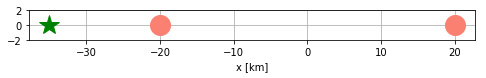

In [2]:
### create an ensemble of sources
dx=40. *1.e3 # in meters
sources=[]
sources.append(source( dx*.5, 0))
sources.append(source(-dx*.5, 0))



Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
r=receiver(-35. *1.e3, 0, e_x=10.e3, e_dt=0.)

### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=None, e_min=1.e-3)  #e_min on time (Cramer-Rao)

### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources]
r.plot()
plt.ylim([-2, 2])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

**- A priori uncertainties and estimates are :**

In [3]:
# a priori uncertainties : 
print("e_c   = %.1f m/s    (uncertainty on celerity)" %pmap.e_c)
# si e_c = 0 alors e_tp = e_min = 1.e-3 s
print("e_dx  = %.1f m     (uncertainty on transducer position)" %sources[0].e_dx)
print("e_x   = %.1f m  (uncertainty on underwater float position)" %r.e_x)

e_c   = 0.0 m/s    (uncertainty on celerity)
e_dx  = 10.0 m     (uncertainty on transducer position)
e_x   = 10000.0 m  (uncertainty on underwater float position)


**- The true underwater float position and clock offset are:**

In [4]:
print('x = %.1f m \ndt = %.2e s' %(r.x, r.dt))

x = -35000.0 m 
dt = 0.00e+00 s


**- Unchanged variables during simulations are : **

In [5]:
print("s.x_t :", [s.x_t for s in sources])   # 
#print("s.y_t :", [s.y_t for s in sources])
print("s.dx  :", [s.dx for s in sources])
#print("s.dy  :", [s.dy for s in sources])
#print("r.dt  :", r.dt)

s.x_t : [array([20002.87740734]), array([-19993.55400541])]
s.dx  : [array([2.87740734]), array([6.44599459])]


---
---
## A - One geolocalisation

In [6]:
r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
r.t_r_tilda

array([36.667033  , 10.00214825])

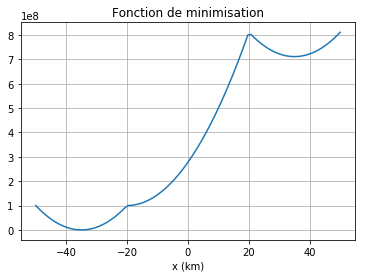

In [7]:
#r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
x, dt, success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, plot_min=True)

In [8]:
print ("L'erreur sur la geolocalisation est de %.2f m." %(abs(r.x - x)))

L'erreur sur la geolocalisation est de 1.89 m.


---
---
## B - Statistical simulations for one receiver position

In [9]:
### minimization with adjusted a priori estimates
Nmc = 1000
x=np.zeros(Nmc)
dt=np.zeros(Nmc)

for i in range(Nmc):
    # solve a first time
    r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
    x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
    # rerun with adjusted expected errors on propagation time
    for j in range(1):
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False, \
                                                                     x0=[x[i], dt[i]])

d_rms = np.sqrt( np.mean( (x - r.x)**2 ) )
bias_x = x.mean()-r.x
print('rms error : %.1f m \nx bias    : %.3f m ' %(d_rms, bias_x))

rms error : 1.1 m 
x bias    : -0.026 m 


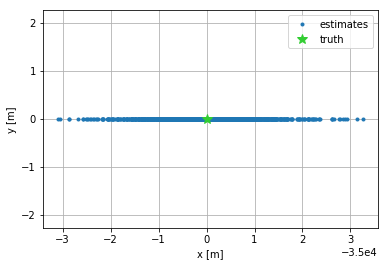

In [10]:
plt.figure()
ax=plt.subplot(111)
ax.plot(x,np.zeros(Nmc),'.', label='estimates')
ax.plot(r.x,r.y,'*', color='limegreen', markersize=10, label='truth')
ax.axis('equal')
ax.grid()
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()

---
# 4 - Transects 

**- Function "simu" : simulations for one receiver position ; returns rms and bias.  **

In [11]:
def simu (r, sources, Nmc, var) : 
    ''' It returns rms and bias on x position for one receiver position'''
    x=np.zeros(Nmc)
    y=np.zeros(Nmc)
    dt=np.zeros(Nmc)
    su = np.zeros (Nmc)
    
    for i in range(Nmc):
        
        if var == 'celerity' : 
            [s.draw_celerity(s.e_c) for s in sources]
        if var == 'dxdy' : 
            [s.draw_dxdy(10.) for s in sources]
        if var == 'clock' : 
            r.draw_clock_drift()
            #dt_truth[i] = r.dt    
        
        # solve a first time
        r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
        x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, clock_drift=False)
        # rerun with adjusted expected errors on propagation time
        for j in range(1):
            x[i], dt[i], success, message, res = geolocalize_xtmap_1D(r, sources, pmap, \
                                                                         clock_drift=False, \
                                                                         x0=[x[i],y[i], dt[i]])
        if success :
            su[i] = 1 
        elif message.find('iterations')!= -1 : 
            # "Warning: Maximum number of iterations has been exceeded."
            su[i] = -1
        elif message.find('precision loss')!= -1 :
            #Warning: Desired error not necessarily achieved due to precision loss.
            su[i] = -2
        else : 
            su[i] = -3
    
    
    # rms error on the receiver position
    d_rms = np.sqrt( np.mean( (x[np.where(su==1)] - r.x)**2 ) )
    # biais on the receiver position
    bias_x = x[np.where(su==1)].mean()-r.x
    bias_y = y[np.where(su==1)].mean()-r.y
    #print('x[np.where(su==1)].mean() :' , x[np.where(su==1)].mean())
    #print('r.x : ', r.x)
    return (d_rms, bias_x, su)




**- Calculation and plot functions for transects : **

In [12]:
from ipywidgets import FloatProgress
from IPython.display import display


def transect (sources, X, Y, Nmc, var) :
    RMS_t = np.zeros((len(X)))
    BiasX_t = np.zeros((len(X)))
    Success_t = np.zeros((Nmc, len(X)))
    
    f = FloatProgress(value = 0., min=0., max=100., step=1., orientation='horizontal', description = 'Loading :')
    display(f)
    
    for i in range (len(X)) :
        
        f.value = i/len(X)*100.

        # init a receiver
        r = receiver(X[i], Y)
        r.dt = 1. # unchanged variable during simulations 
        #
        d_rms, bias_x, su = simu (r, sources, Nmc, var = var)

        RMS_t[i]       = d_rms
        BiasX_t[i]     = bias_x
        Success_t[:,i] = su

    f.value = 100.
    
    return RMS_t, BiasX_t, Success_t


def plot_transect (sources, X, Y, RMS_t, Biais_t):
    print('mean (rms) = %.1fm  /// max (rms) = %.1f m' % (np.mean(RMS_t), np.max(RMS_t)))
    print('mean (bias) = %.1fm /// max (bias) = %.1f m' % (np.mean(Biais_t), np.max(Biais_t)))
    plt.figure(figsize=(17,4))
    # plot sources 
    ax=plt.subplot(131)
    [s.plot() for s in sources]
    plt.title ('sources and transect')
    plt.xlabel('x [km]')
    plt.ylabel('y [km]')
    ax.grid()
    #ax.set_xlim([np.min(X)/1000.,np.max(X)/1000.])
    ax.set_ylim([-abs(sources[0].y_s)/1000. - 5., abs(sources[0].y_s)/1000. + 5.])
    ax.set_aspect('equal')
    plt.plot([np.min(X)/1000.,np.max(X)/1000.],[Y/1000.,Y/1000.],'.-b')

    ## plot rms result
    ax2 = plt.subplot(132)
    ax2.grid()
    plt.plot(X/1.e3, RMS_t, '.') 
    plt.xlabel('x [km]')
    plt.ylabel('RMS [m]')
    plt.title('RMS error' )
    
    ## plot bias
    ax3  = plt.subplot(133)
    ax3.grid()
    plt.plot(X/1.e3, Biais_t, '.')
    plt.xlabel('x [km]')
    plt.ylabel('Bias [m]')
    plt.title('Bias on x ' )
    
    plt.show()
    

**- Creation of a transect : **

In [13]:
L = 100.* 1.e3
X = np.linspace(-L/2.,L/2.,100)  # resolution : 1km
Y = 0. 

**- Calculations and plots : **

In [14]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 1.1m  /// max (rms) = 1.3 m
mean (bias) = 0.0m /// max (bias) = 0.3 m


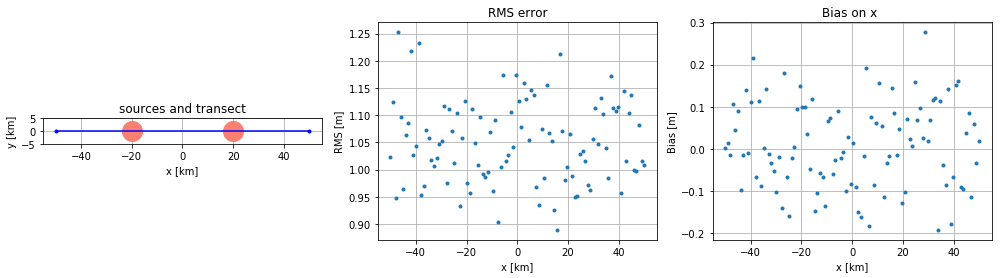

In [15]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

---
---
---
Au dessus, l'erreur sur la célérité était considérée comme nulle et la seule erreur prise en compte était de 1.e-3s (erreur sur la détection du temps d'arrivée). 

Maintenant, on augmente l'erreur sur le temps d'arrivée (dû à une détection du mauvais rayon ou autre...). D'après les calculs de célérité équivalente (en Méditerrannée), on a un ecart-type sur la distance de 70m environ. Cela correspond à un cart type sur les temps d'arrivée de 0.045s.

---
---
---

### Avec une erreur sur le temps d'arrivée de 10 ms 

In [16]:
### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-2, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [17]:
r.t_r_tilda = np.array([s.t_e+pmap.draw_t(dist(s,r))+r.dt for s in sources]).squeeze()
r.t_r_tilda

array([36.66520547, 10.01263026])

In [18]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 10.5m  /// max (rms) = 12.1 m
mean (bias) = -0.1m /// max (bias) = 2.3 m


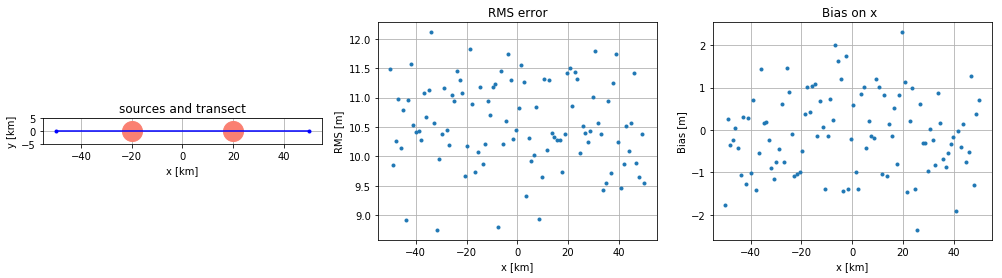

In [19]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

---
---
### Avec une erreur sur le temps d'arrivée de 100 ms 

In [20]:
### init mapping
pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-1, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [21]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources, X, Y, Nmc, var)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 105.7m  /// max (rms) = 129.0 m
mean (bias) = 1.4m /// max (bias) = 26.0 m


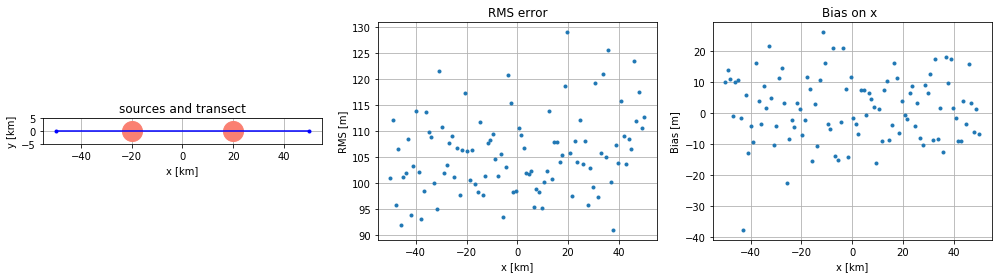

In [22]:
plot_transect(sources, X, Y, RMS_t, BiasX_t)

---
---
### En ajoutant 2 sources

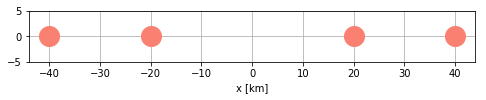

In [23]:
### create an ensemble of sources
dx=40. *1.e3 # in meters
sources1=[]
sources1.append(source( dx*.5, 0))
sources1.append(source(-dx*.5, 0))
sources1.append(source( dx, 0))
sources1.append(source(-dx, 0))

Ns = len(sources)

### init a receiver
#r=receiver(0. *1.e3, 0. *1.e3, e_x=10.e3)
#r=receiver(-35. *1.e3, 0, e_x=10.e3, e_dt=0.)


### plot
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
[s.plot() for s in sources1]
#r.plot()
plt.ylim([-5, 5])
ax.grid()
ax.set_aspect('equal')
plt.xlabel('x [km]')
plt.show()

In [24]:
### init mapping  (we keep the one of previous section)
#pmap = xtmap(c_b=1500., e_c=0., e_t=1.e-1, e_min=1.e-3)  #e_min on time (Cramer-Rao)

In [25]:
Nmc = 100          # number of simulations
var = 'celerity'   # only celerity is varying
RMS_t, BiasX_t, Success_t = transect (sources1, X, Y, Nmc, var)

FloatProgress(value=0.0, description='Loading :')

mean (rms) = 76.1m  /// max (rms) = 88.2 m
mean (bias) = -0.8m /// max (bias) = 18.8 m


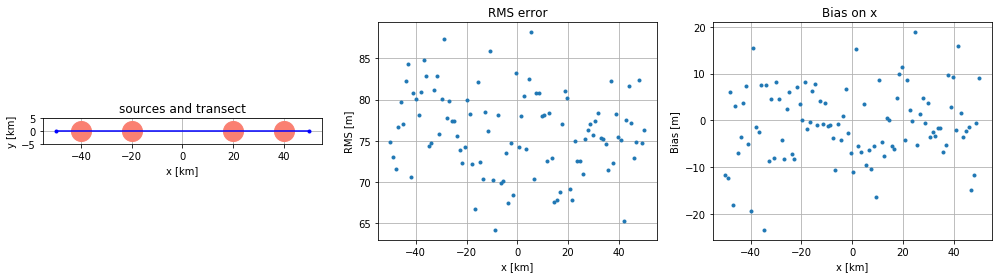

In [26]:
plot_transect(sources1, X, Y, RMS_t, BiasX_t)

---
---
### Avec une dérive d'horloge

In [27]:
### prendre une valeur inférieure à 1s